In [152]:
%pip install Prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

C:\Users\trinh\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [7]:
df = pd.read_csv('BTC-Daily.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [8]:
df.shape

(2651, 9)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB


In [10]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df.drop(['unix', 'symbol', 'Volume USD'], axis=1)
df = df.rename(columns={'date': 'Ngày'})
df = df.rename(columns={'open': 'Giá mở'})
df = df.rename(columns={'high': 'Cao nhất'})
df = df.rename(columns={'low': 'Thấp nhất'})
df = df.rename(columns={'close': 'Giá đóng'})
df = df.rename(columns={'Volume BTC': 'Khối lượng'})
df.head()

,Ngày,Giá mở,Cao nhất,Thấp nhất,Giá đóng,Khối lượng
0,2022-03-01,43221.71,43626.49,43185.48,43185.48,49.006289
1,2022-02-28,37717.10,44256.08,37468.99,43178.98,3160.618070
2,2022-02-27,39146.66,39886.92,37015.74,37712.68,1701.817043
3,2022-02-26,39242.64,40330.99,38600.00,39146.66,912.724087
4,2022-02-25,38360.93,39727.97,38027.61,39231.64,2202.851827


In [11]:
df = df.sort_values('Ngày')
df.head()

,Ngày,Giá mở,Cao nhất,Thấp nhất,Giá đóng,Khối lượng
2650,2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2649,2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2648,2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2647,2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2646,2014-12-02,378.39,382.86,375.23,379.25,2593576.46


In [12]:
print(df[['Giá mở', 'Cao nhất', 'Thấp nhất', 'Giá đóng', 'Khối lượng']].describe())

             Giá mở      Cao nhất     Thấp nhất      Giá đóng    Khối lượng
count   2651.000000   2651.000000   2651.000000   2651.000000  2.651000e+03
mean   11693.189332  12038.562912  11296.539461  11709.326213  1.330041e+07
std    16272.554746  16739.237000  15718.297511  16282.908704  4.715366e+07
min      162.000000    212.840000    152.400000    162.000000  0.000000e+00
25%      654.680000    664.460000    640.050000    654.370000  5.357883e+03
50%     6408.950000   6540.000000   6312.000000   6407.770000  1.503310e+04
75%    10708.620000  10956.240000  10303.755000  10726.425000  3.435336e+06
max    67547.490000  69000.000000  66250.000000  67559.000000  7.723295e+08


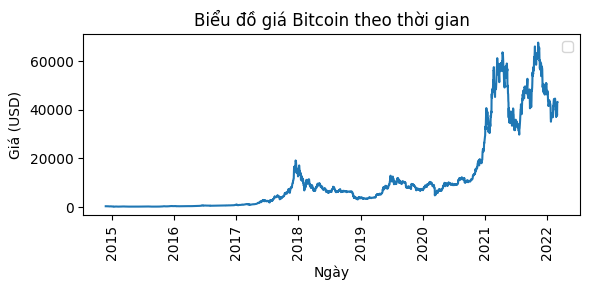

In [13]:
plt.figure(figsize=(6, 3))
plt.plot(df['Ngày'], df['Giá đóng'])
plt.title('Biểu đồ giá Bitcoin theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

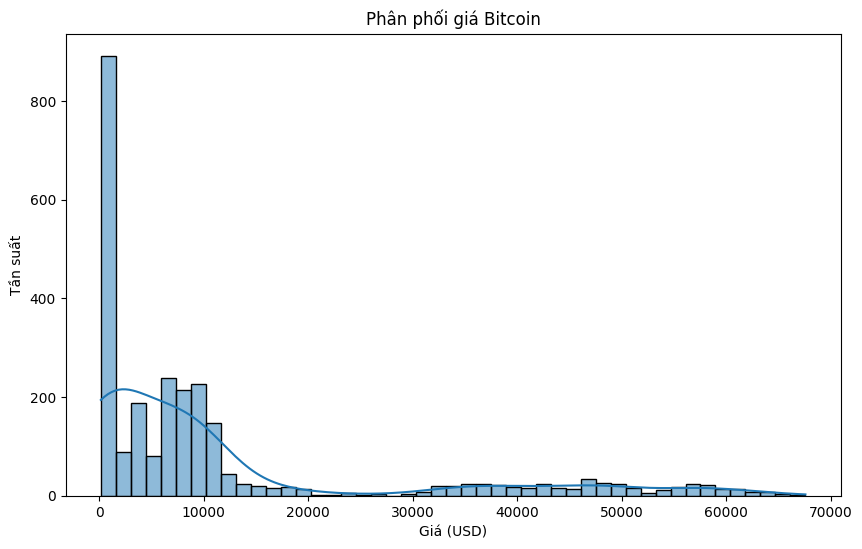

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Giá đóng'], kde=True)
plt.title('Phân phối giá Bitcoin')
plt.xlabel('Giá (USD)')
plt.ylabel('Tần suất')
plt.show()

## Prophet Model

In [162]:
prophet_df = df[['Ngày', 'Giá đóng']].rename(columns={'Ngày': 'ds', 'Giá đóng': 'y'})

In [163]:
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

In [164]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train_df)

15:07:03 - cmdstanpy - INFO - Chain [1] start processing
15:07:03 - cmdstanpy - INFO - Chain [1] done processing


In [169]:
future = model.make_future_dataframe(periods=len(test_df) + 3)
forecast = model.predict(future)

In [170]:
forecast_test = forecast[(forecast['ds'] >= test_df['ds'].min()) & (forecast['ds'] <= test_df['ds'].max())]
y_pred = forecast_test['yhat'].values
y_true = test_df['y'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"\nĐánh giá mô hình dự đoán:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Đánh giá mô hình dự đoán:
Mean Absolute Error: 30667.29
Root Mean Squared Error: 34109.29


In [171]:
import matplotlib.dates as mdates

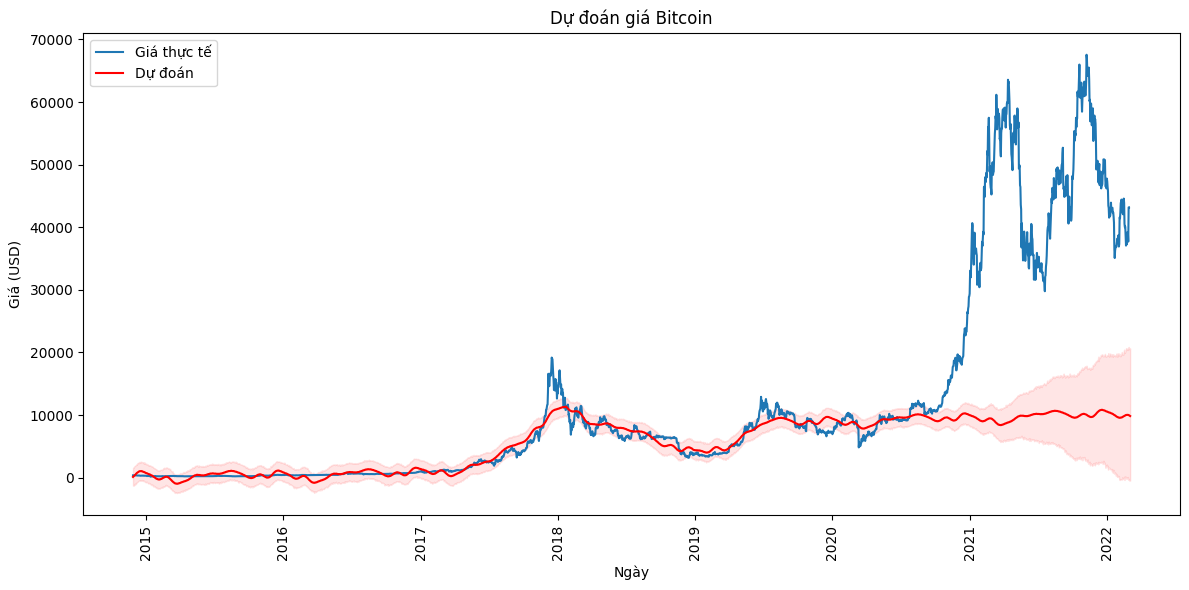

In [172]:
plt.figure(figsize=(12, 6))
plt.plot(df['Ngày'], df['Giá đóng'], label='Giá thực tế')
plt.plot(forecast['ds'], forecast['yhat'], label='Dự đoán', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1)

plt.title('Dự đoán giá Bitcoin')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [173]:
print("Ngày cuối cùng trong dữ liệu huấn luyện:", last_train_date)

Ngày cuối cùng trong dữ liệu huấn luyện: 2022-03-01 00:00:00


In [174]:
print(forecast[forecast['ds'] > last_train_date].head())

             ds         trend  yhat_lower    yhat_upper  trend_lower  \
2651 2022-03-02  10246.246058 -474.963048  20719.391522   110.282404   
2652 2022-03-03  10247.779802 -465.048311  20526.346405    96.702941   
2653 2022-03-04  10249.313547 -458.031992  20656.914571    47.576802   

       trend_upper  additive_terms  additive_terms_lower  \
2651  20789.862351     -302.503191           -302.503191   
2652  20812.401184     -369.771503           -369.771503   
2653  20834.940016     -399.060151           -399.060151   

      additive_terms_upper      daily  ...     weekly  weekly_lower  \
2651           -302.503191 -68.708063  ...   5.482216      5.482216   
2652           -369.771503 -68.708063  ... -19.895099    -19.895099   
2653           -399.060151 -68.708063  ...  -1.742265     -1.742265   

      weekly_upper      yearly  yearly_lower  yearly_upper  \
2651      5.482216 -239.277344   -239.277344   -239.277344   
2652    -19.895099 -281.168341   -281.168341   -281.168341   

In [175]:
last_train_date = prophet_df['ds'].max()

future_only = forecast[forecast['ds'] > last_train_date].head(3)

print("\nDự đoán giá Bitcoin trong 3 ngày tới:")
print("\nNgày\t\t\tTin cậy (USD)\tThấp nhất\tCao nhất")
print("-" * 80)
for _, row in future_only.iterrows():
    date = row['ds'].strftime('%d/%m/%Y')
    price = f"{row['yhat']:,.2f}"
    lower = f"{row['yhat_lower']:,.2f}"
    upper = f"{row['yhat_upper']:,.2f}"
    print(f"{date}\t{price:>15}\t{lower:>15} - {upper:>15}")



Dự đoán giá Bitcoin trong 3 ngày tới:

Ngày			Tin cậy (USD)	Thấp nhất	Cao nhất
--------------------------------------------------------------------------------
02/03/2022	       9,943.74	        -474.96 -       20,719.39
03/03/2022	       9,878.01	        -465.05 -       20,526.35
04/03/2022	       9,850.25	        -458.03 -       20,656.91


## LSTM Model

In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [15]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Giá đóng']].values)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0028 - val_loss: 1.5679e-04
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3645e-04 - val_loss: 1.4210e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2124e-04 - val_loss: 1.4233e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4975e-04 - val_loss: 1.5336e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9422e-04 - val_loss: 1.2482e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7239e-04 - val_loss: 3.0374e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9800e-04 - val_loss: 1.0678e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7809e-04 - val_loss: 9.5703e-05
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9825e-04 - val_loss: 2.6226e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6264e-04 - val_loss: 9.0524e-05
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4043e-04 - 

In [18]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

train_mae = mean_absolute_error(y_train_orig, train_predictions)
test_mae = mean_absolute_error(y_test_orig, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_predictions))

print("\nĐánh giá mô hình LSTM:")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Đánh giá mô hình LSTM:
Train MAE: 234.47
Test MAE: 3905.61
Train RMSE: 414.38
Test RMSE: 4692.03


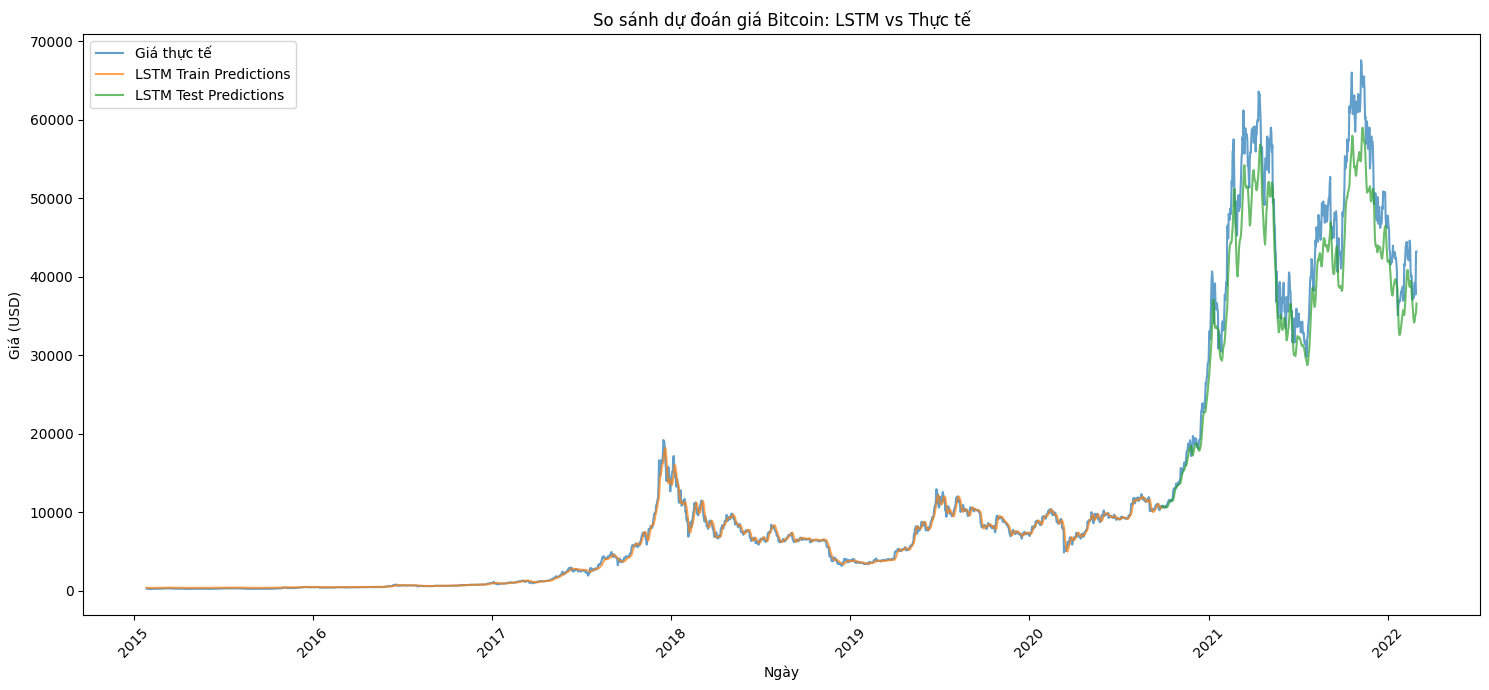

In [20]:
plt.figure(figsize=(15, 7))

plt.plot(df['Ngày'][sequence_length:], df['Giá đóng'][sequence_length:], label='Giá thực tế', alpha=0.7)

train_dates = df['Ngày'][sequence_length:sequence_length+len(train_predictions)]
test_dates = df['Ngày'][sequence_length+len(train_predictions):sequence_length+len(train_predictions)+len(test_predictions)]

plt.plot(train_dates, train_predictions, label='LSTM Train Predictions', alpha=0.7)
plt.plot(test_dates, test_predictions, label='LSTM Test Predictions', alpha=0.7)

plt.title('So sánh dự đoán giá Bitcoin: LSTM vs Thực tế')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



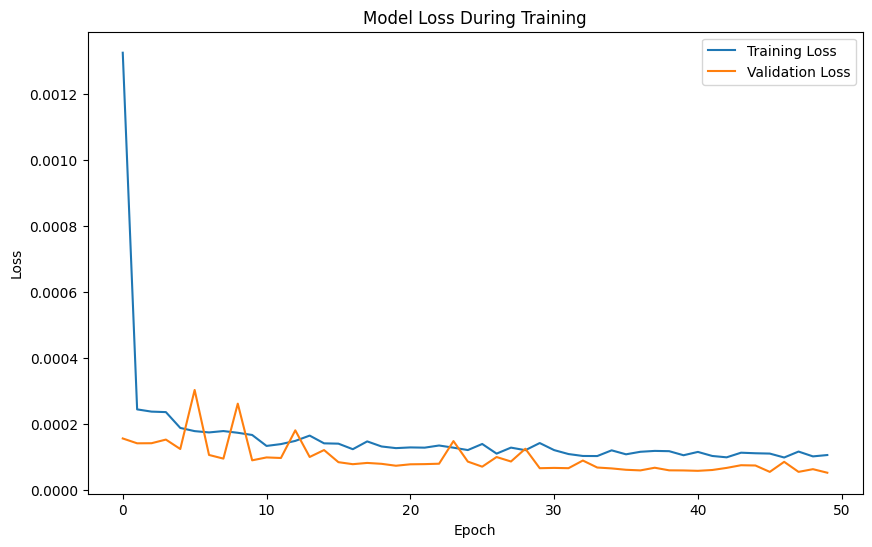

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
last_sequence = scaled_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))

lstm_predictions = []
for _ in range(3):
    next_pred = model.predict(last_sequence)
    lstm_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = next_pred[0, 0]

lstm_predictions = np.array(lstm_predictions).reshape(-1, 1)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

last_date = df['Ngày'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=3, freq='D')

print("\nDự đoán giá Bitcoin 3 ngày tới với LSTM:")
for date, pred in zip(future_dates, lstm_predictions):
    print(f"{date.strftime('%d/%m/%Y')}: ${pred[0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Dự đoán giá Bitcoin 3 ngày tới với LSTM:
02/03/2022: $37,914.63
03/03/2022: $37,592.90
04/03/2022: $36,639.05
